# In this notebook I did data analysis on each individual subreddit that had been cleaned in notebook one. Notebook 2 moves on to modeling on the concated dataframe

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
import time
import requests
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import praw
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
from IPython.core.interactiveshell import InteractiveShell
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# load the two cleaned datasets

In [15]:
aadf=pd.read_csv('./data/AlienAbductionsCLEANED.csv')

In [16]:
spdf=pd.read_csv('./data/SleepParalysisCLEANED.csv')

In [17]:
aadf.head()

,Unnamed: 0,title,subreddit,num_comments,body
0,0,25 Space Facts That Will Both Terrify And Amaz...,Abductions,0,0
1,1,BF hearing voices,Abductions,5,So my boyfriend just shared with me his experi...
2,2,Is Blue Ink a Sign?,Abductions,1,When I was a teen I would go to my dads house ...
3,3,Mauritius oil spill: Experts fear catastrophic...,Abductions,4,0
4,4,Should I continue posting Finding Truth?,Abductions,17,Let's have it already.\n\n[View Poll](https://...


In [18]:
spdf.head()

,Unnamed: 0,title,subreddit,num_comments,body
0,0,Identifying SP,Sleepparalysis,177,I’m making this because 75% of this sub is peo...
1,1,is it normal to experience sleep paralysis mul...,Sleepparalysis,19,"for background, ive missed a couple doses of m..."
2,2,oh no,Sleepparalysis,0,isn’t water just a snowman’s blood?? 🤯🤯🤔🤔
3,3,Something that works for me with preventing SP...,Sleepparalysis,1,Not sure it will work for other people but it ...
4,4,The moment I fall asleep I wake up in a panic ...,Sleepparalysis,0,This has only been happening for a few months....


## drop unnamed columns

In [19]:
aadf=aadf.drop(columns=['Unnamed: 0'])
spdf=spdf.drop(columns=['Unnamed: 0'])

## insert a column called subreddit2 that has 1 for sleep paralysis and 0 for alien abduction.

In [20]:
aadf.insert(2,'subreddit2',0)

In [21]:
spdf.insert(2,'subreddit2',1)

## create columns: body length, body word count, title length and title word length for both data sets

In [22]:
aadf['body_length'] = aadf['body'].map(len)

In [23]:
aadf['body_word_count'] = aadf['body'].map(lambda x: len(x.split()))

In [24]:
spdf['body_length'] = spdf['body'].map(len)

In [25]:
spdf['body_word_count'] = spdf['body'].map(lambda x: len(x.split()))

In [26]:
aadf['title_length'] = aadf['title'].map(len)

In [27]:
aadf['title_word_count'] = aadf['title'].map(lambda x: len(x.split()))

In [28]:
spdf['title_length'] = spdf['title'].map(len)

In [29]:
spdf['title_word_count'] = spdf['title'].map(lambda x: len(x.split()))

## Distribution plot with body word count of each subreddit

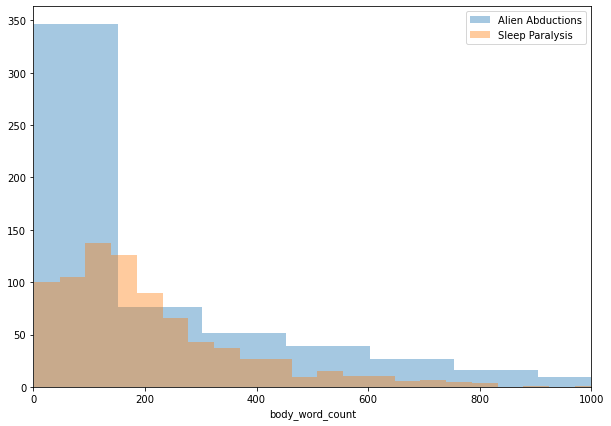

In [102]:
plt.figure(figsize=(10,7))
sns.distplot(aadf[aadf['subreddit2'] == 0]['body_word_count'], kde=False, label='Alien Abductions')
sns.distplot(spdf[spdf['subreddit2'] == 1]['body_word_count'], kde=False, label='Sleep Paralysis')

plt.xlim(0,1000)
plt.legend();

In [31]:
df['title_length'] = df['title'].map(len)

In [32]:
df['title_word_count'] = df['title'].map(lambda x: len(x.split()))

## Distribution plot with title word count of each subreddit

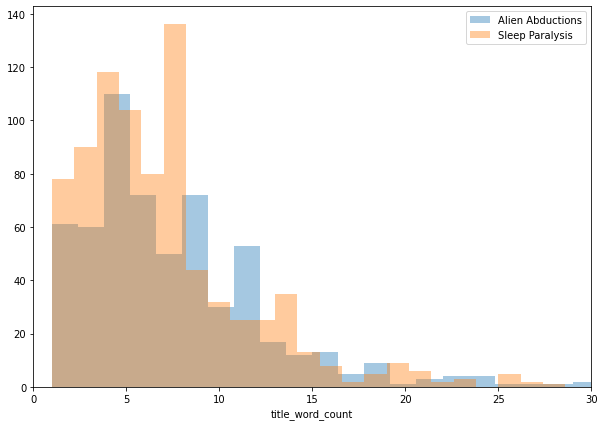

In [103]:
plt.figure(figsize=(10,7))
sns.distplot(aadf[aadf['subreddit2'] == 0]['title_word_count'], kde=False, label='Alien Abductions')
sns.distplot(spdf[spdf['subreddit2'] == 1]['title_word_count'], kde=False, label='Sleep Paralysis')

plt.xlim(0,30)
plt.legend();

### Define stop words for Sleep Paralysis (some of these I added after looking at the coefficients)

In [38]:
stop=stopwords.words('english')+['like','sleep','paralysis','could','would','see','get','something','sp']

## Vectorize for Sleep Paralysis

In [39]:
vectorizer=CountVectorizer(analyzer='word',
                          tokenizer=None,
                          preprocessor=None,
                          stop_words=stop,
                          
                          min_df=.07)

In [40]:
X_vecsp=vectorizer.fit_transform(df['body'])

In [41]:
X_vecdfsp=pd.DataFrame(X_vecsp.toarray(),columns=vectorizer.get_feature_names())

In [107]:
X_vecdfsp.head()

,10,abduction,able,actually,ago,alien,aliens,almost,also,always,...,weird,well,went,white,whole,window,woke,work,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Combine the sleep paralysis df with the vectorized df

In [43]:
spdf = pd.concat([spdf, X_vecdfsp],axis=1)

In [44]:
spdf.head(1)

,title,subreddit,subreddit2,num_comments,body,body_length,body_word_count,title_length,title_word_count,10,...,weird,well,went,white,whole,window,woke,work,year,years
0,Identifying SP,Sleepparalysis,1.0,177.0,I’m making this because 75% of this sub is peo...,3604.0,632.0,14.0,2.0,0,...,0,0,0,0,0,0,0,0,0,0


## Create a df with the most frequently used words in the Sleep Paralysis reddit

In [109]:
# I got this and the bar chart from class notes
top_words = {}

# loop through columns
for i in X_vecdfsp.columns:
    # save sum of each column in dictionary
    top_words[i] =  X_vecdfsp[i].sum()

most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))

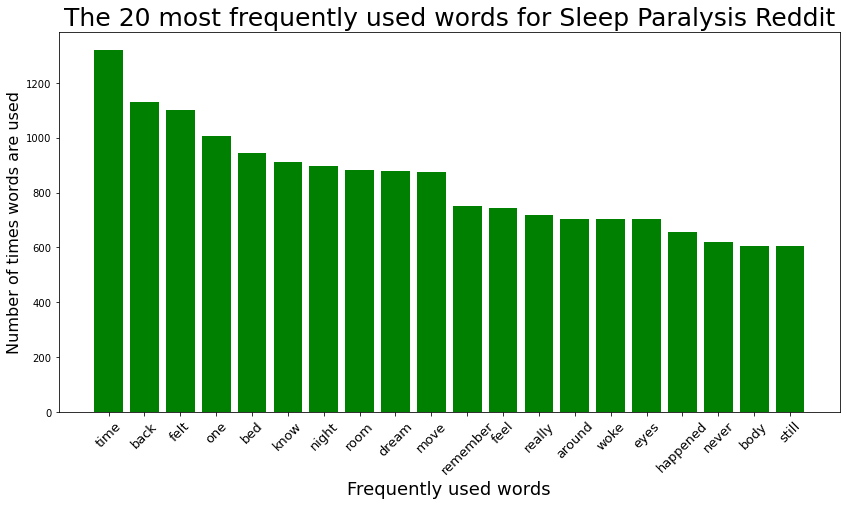

In [110]:
plt.figure(figsize = (14, 7))

# bar chart of the top 20 words
plt.bar(most_freq[0][:20],most_freq[1][:20],color='green')
plt.title('The 20 most frequently used words for Sleep Paralysis Reddit',size=25)
plt.xlabel('Frequently used words',size=18)
plt.ylabel('Number of times words are used',size=16)
plt.xticks(rotation=45,size=13);

In [105]:
#most frequently used words in sleep paralysis subreddit ranked
most_freq['words']

0         time
1         back
2         felt
3          one
4          bed
        ...   
215    noticed
216      often
217       week
218       gone
219     reason
Name: words, Length: 220, dtype: object

### Define stop words Alien Abductions (some of these I added after looking at the coefficients)

In [53]:
stop2=stopwords.words('english')+['like','could','would','see','get','something','abducted','abduction','abductions','alien','aliens']

## Vectorize for Alien Abductions

In [54]:
vectorizer=CountVectorizer(analyzer='word',
                          tokenizer=None,
                          preprocessor=None,
                          stop_words=stop2,
                          
                          min_df=.07)

In [55]:
X_vecaa=vectorizer.fit_transform(aadf['body'])

In [56]:
X_vecdfaa=pd.DataFrame(X_vecaa.toarray(),columns=vectorizer.get_feature_names())

In [57]:
X_vecdfaa.head()

,10,able,actually,ago,almost,also,always,another,anyone,anything,...,went,whatever,white,whole,window,without,woke,work,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,3,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Combine the Alien Abduction df with the vectorized df

In [58]:
aadf = pd.concat([aadf, X_vecdfaa],axis=1)

In [59]:
aadf.head(1)

,title,subreddit,subreddit2,num_comments,body,body_length,body_word_count,title_length,title_word_count,10,...,went,whatever,white,whole,window,without,woke,work,year,years
0,25 Space Facts That Will Both Terrify And Amaz...,Abductions,0,0,0,1,1,51,10,0,...,0,0,0,0,0,0,0,0,0,0


## Create a df with the most frequently used words in the Alien Abduction reddit

In [111]:
# I got this and the bar chart from class notes
top_words2 = {}

# loop through columns
for i in X_vecdfaa.columns:
    # save sum of each column in dictionary
    top_words2[i] =  X_vecdfaa[i].sum()

most_freq2 = pd.DataFrame(sorted(top_words2.items(), key = lambda x: x[1], reverse = True))

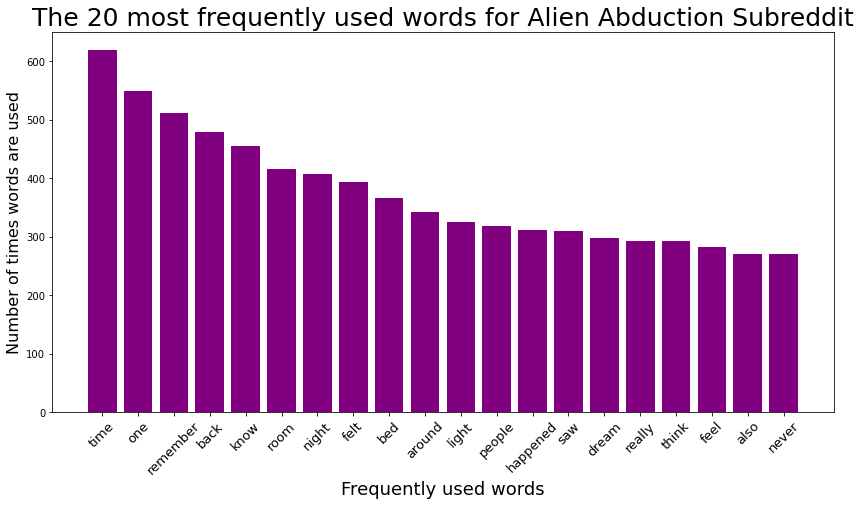

In [112]:
plt.figure(figsize = (14, 7))

# bar chart of the top 20 words
plt.bar(most_freq2[0][:20],most_freq2[1][:20],color='purple')
plt.title('The 20 most frequently used words for Alien Abduction Subreddit',size=25)
plt.xlabel('Frequently used words',size=18)
plt.ylabel('Number of times words are used',size=16)
plt.xticks(rotation=45,size=13);

In [93]:
#most frequently used words in the Alien Abduction subreddit ranked
most_freq

,words,count
0,time,1321
1,back,1132
2,felt,1102
3,one,1007
4,bed,944
...,...,...
215,noticed,125
216,often,125
217,week,124
218,gone,123


### combining both frequently used words into one df to compare

In [92]:
most_freq=most_freq.drop(columns=[1,0])

In [86]:
most_freq2['words2']=most_freq2[0]

In [85]:
most_freq2['count2']=most_freq2[1]

In [89]:
most_freq2

,count2,words2
0,620,time
1,550,one
2,511,remember
3,479,back
4,455,know
...,...,...
239,53,guess
240,53,turn
241,52,telling
242,51,months


In [88]:
most_freq2=most_freq2.drop(columns=[1,0,'words'])

In [95]:
mostfreq_combined= pd.concat([most_freq2, most_freq],axis=1)

In [94]:
type(most_freq2)

pandas.core.frame.DataFrame

In [96]:
mostfreq_combined

,count2,words2,words,count
0,620,time,time,1321.0
1,550,one,back,1132.0
2,511,remember,felt,1102.0
3,479,back,one,1007.0
4,455,know,bed,944.0
...,...,...,...,...
239,53,guess,NaN,NaN
240,53,turn,NaN,NaN
241,52,telling,NaN,NaN
242,51,months,NaN,NaN
